In [1]:
pip install ipynb-py-convert

  Stored in directory: /Users/wakilahmad/Library/Caches/pip/wheels/80/dc/7c/a7279f7726d66951fe48d5afd45247bcf5bf92c98282e4e78e
Successfully built ipynb-py-convert
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, auc
import numpy as np

#from rotation_forest import RotationForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, roc_auc_score
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from rotation_forest import RotationForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from collections import defaultdict


def conver_to_tensor(y_true, y_pred):
    return tf.convert_to_tensor(y_true, np.float32), tf.convert_to_tensor(y_pred, np.float32)


def correlation_coefficient_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)


def matthews_correlation(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def matthews_correlation_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return (-(numerator / (denominator + K.epsilon()))+1)*100


def sensitivity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


def specificity_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.clip((1-y_true) * (1-y_pred), 0, 1))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return - (true_negatives / (possible_negatives + K.epsilon()))


def recall_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 1 - 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def robust_cross_val(x_train, y_train, x_test, y_test, folds):
    skf = StratifiedKFold(n_splits=folds)
    #skf = KFold(n_splits=folds)
    #skf = RepeatedKFold(n_splits=folds, n_repeats=2, random_state=42)

    model = LogisticRegression()
    #model = svm.SVC(kernel='linear', degree=3, gamma='scale')
    #model = svm.SVC(kernel='poly', degree=3, gamma='scale')
    #model = svm.SVC(kernel='rbf', degree=3, gamma='scale')
    #model = svm.SVC(kernel='sigmoid', degree=3, gamma='scale')
    #model = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=1)
    #model = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, max_features='auto', min_impurity_split=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, random_state=0, warm_start=False)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    #model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1, max_iter=300, learning_rate='constant', learning_rate_init=0.001)
    #model = MLPClassifier(random_state=1, max_iter=300)
    #model = AdaBoostClassifier(n_estimators=100, random_state=0)
    #model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)

    accuracy = []
    mcc = []
    precision = []
    roc_auc = []
    Sensitivity = []
    Specificity = []
    auc_score = []
    f1 = []
    score = []

    for x in range(10):
        for train_index, test_index in skf.split(x_train, y_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]

            model.fit(X_train, Y_train)
            y_predict = model.predict(X_test)
            score.append(model.score(X_test, Y_test))

            accuracy.append(accuracy_score(Y_test, y_predict))
            mcc.append(matthews_corrcoef(Y_test, y_predict))
            precision.append(precision_score(Y_test, y_predict))
            roc_auc.append(roc_auc_score(Y_test, y_predict))
            auc_score.append(auc(Y_test, y_predict))
            f1.append(f1_score(Y_test, y_predict))
            Sensitivity.append(sensitivity(Y_test, y_predict))
            Specificity.append(specificity(Y_test, y_predict))

    with open('./model/LoR.pkl', 'wb') as f:
        pickle.dump(model, f)

    res = "{} folds\n".format(folds)
    res += "******************** Cross Validation Score ********************\n"
    res += "Accuracy: {}\n".format(np.mean(accuracy))
    res += "MCC: {}\n".format(np.mean(mcc))
    res += "Precision: {}\n".format(np.mean(precision))
    res += "Roc AUC score: {}\n".format(np.mean(roc_auc))
    res += "F1 score: {}\n".format(np.mean(f1))
    res += "Sensitivity: {}\n".format(np.mean(Sensitivity))
    res += "Specifity: {}\n".format(np.mean(Specificity))

    y_test_predict = model.predict(x_test)
    res += "\n******************** Independent Test Score ********************\n"
    res += "Accuracy: {}\n".format(accuracy_score(y_test, y_test_predict))
    res += "MCC: {}\n".format(matthews_corrcoef(y_test, y_test_predict))
    res += "Precision: {}\n".format(precision_score(y_test, y_test_predict))
    res += "Roc AUC score: {}\n".format(roc_auc_score(y_test, y_test_predict))
    res += "F1 score: {}\n".format(f1_score(y_test, y_test_predict))
    res += "Sensitivity: {}\n".format(sensitivity(y_test, y_test_predict))
    res += "Specifity: {}\n\n\n".format(specificity(y_test, y_test_predict))

    with open('./results/LoR.txt', 'a') as f:
        f.write(res)

if __name__ == '__main__':
    # from google.colab import files
    # npzfile = files.upload(allow_pickle=True)
    npzfile = np.load('knn_features_007_K-375.npz', allow_pickle=True)
    X_p = npzfile['arr_0']
    Y_p = npzfile['arr_1']
    X_n = npzfile['arr_2']
    Y_n = npzfile['arr_3']

    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(X_p, Y_p, test_size=0.2, shuffle=True, random_state=42)
    x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(X_n, Y_n, test_size=0.2, shuffle=True, random_state=42)

    x_train = np.concatenate((x_train_p, x_train_n)).astype(np.float)
    x_test = np.concatenate((x_test_p, x_test_n)).astype(np.float)
    y_train = np.concatenate((y_train_p, y_train_n)).astype(np.float)
    y_test = np.concatenate((y_test_p, y_test_n)).astype(np.float)

    # x_train = np.concatenate(x_train_p).astype(np.float)
    # x_test = np.concatenate(x_test_p).astype(np.float)
    # y_train = np.concatenate(y_train_p).astype(np.float)
    # y_test = np.concatenate(y_test_p).astype(np.float)

    x_train = x_train.reshape(len(x_train), 456)
    x_test = x_test.reshape(len(x_test), 456)

    robust_cross_val(x_train, y_train, x_test, y_test, 10)


c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

In [2]:
print(robust_cross_val)

<function robust_cross_val at 0x0000027605974678>


In [7]:
print(x_train.shape)
print(y_train.shape)

(1772, 456)
(1772,)


/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


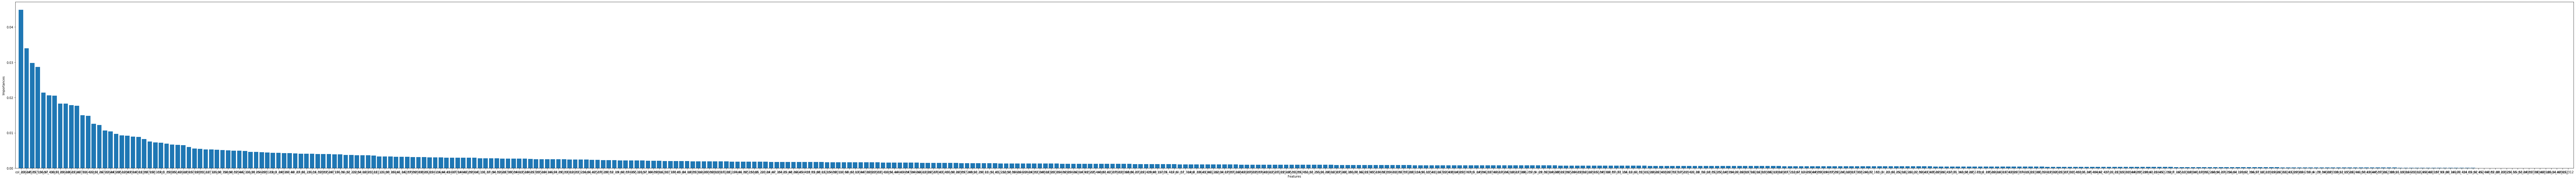

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
feat_importances = model.feature_importances_
indices = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(150, 10))
plt.bar(range(x_train.shape[1]), feat_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), ["col_"+str(i) for i in indices])
plt.xlim([-1, x_train.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.savefig("Feature Importances", bbox_inches='tight')
plt.show()

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score
import matplotlib.pyplot as plt 
curves = []

def plt_curve(lst, name):
  plt.figure(figsize=(20,10))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
    
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

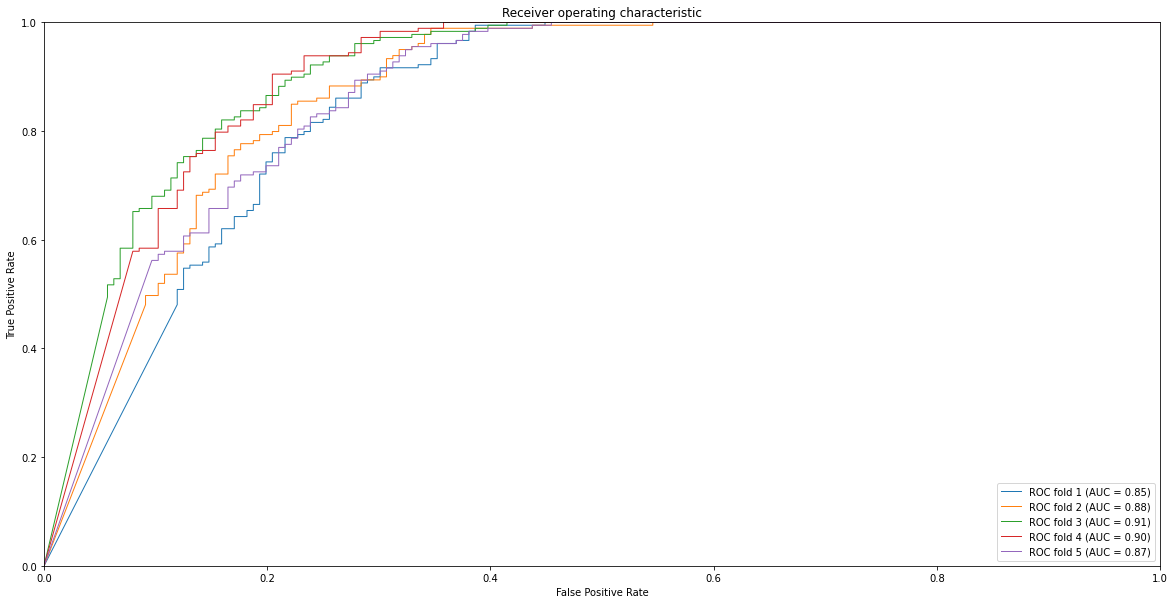

***CROSS VALIDATION***
GNB


{'fit_time': array([0.05099797, 0.06599522, 0.06399822, 0.04999971, 0.06399894]),
 'score_time': array([0.05899048, 0.11099935, 0.04799223, 0.05399132, 0.06499815]),
 'test_roc_plt': array([1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.42938784, 0.48646101, 0.53533232, 0.57173741, 0.48339001]),
 'test_sensitivity_score': array([0.55865922, 0.59217877, 0.58426966, 0.67977528, 0.61797753]),
 'test_specificity_score': array([0.85227273, 0.875     , 0.92045455, 0.88068182, 0.85227273])}

In [19]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
classifier = GaussianNB()
# Names = []
# classifier = []
# estimators = {
#               "LogisticRegression": LogisticRegression(),  
#               "GaussianNB": GaussianNB()
# }


# for key, value in estimators.items():
#     Names.append(key)
#     classifier.append(value)
        
        

curves = []

scores = cross_validate(classifier, 
                        x_train, 
                        y_train, 
                        cv=5,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "GNB CV")
print("***CROSS VALIDATION***")
print("GNB")
scores
#scores['roc']=curves

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(10,7))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(10,7))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=2, label='Precision-Recall fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


***Independent Test***
matthews_corrcoef for LR:  0.9552139315298966

sensitivity_score for LR:  0.96875

specificity_score for LR:  0.9864253393665159

***Independent Test***
matthews_corrcoef for SVM:  0.9910514091507849

sensitivity_score for SVM:  0.9910714285714286

specificity_score for SVM:  1.0



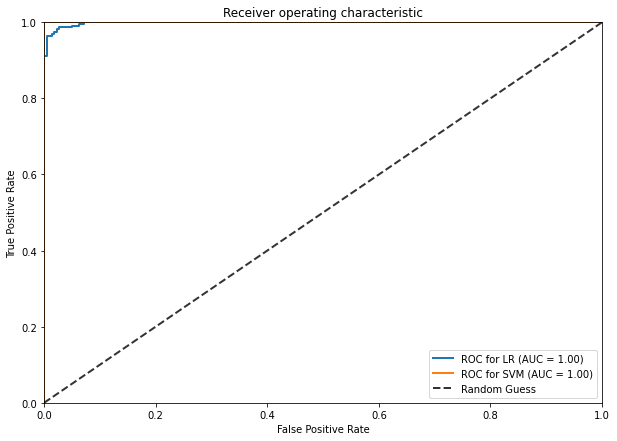

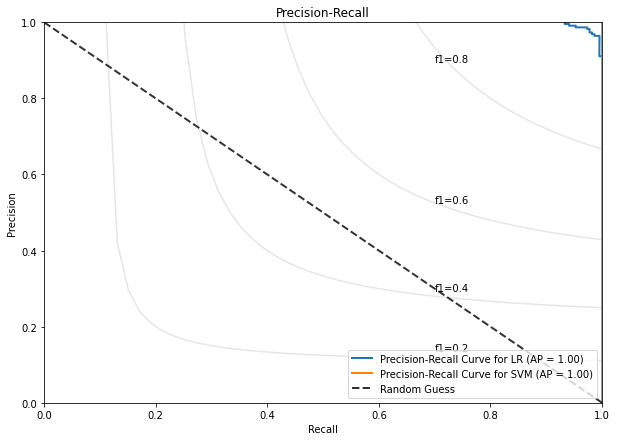

In [23]:
estimators = {"LR": LogisticRegression(),
             "SVM": SVC(kernel='rbf', gamma='scale', probability=True)}

probas_pred = []
avg_pre = []

plt.figure(figsize=(10,7))

# model.fit(X_train, Y_train)
# y_predict = model.predict(X_test)
# score.append(model.score(X_test, Y_test))


for key, clf in estimators.items():
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  y_score = clf.predict_proba(x_test)
  probas_pred.append(y_score)
  avg_pre.append(average_precision_score(y_test, y_score[:, 1], pos_label=1))

  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(fpr, tpr, lw=2, label='ROC for %s (AUC = %0.2f)' % (key, auc(fpr, tpr)))
  print("***Independent Test***")
  mat_cor_coef = matthews_corrcoef(y_test, y_pred)
  print("matthews_corrcoef for " + key + ": ", mat_cor_coef)
  print()

  sen_scr = sensitivity_score(y_test, y_pred)
  print("sensitivity_score for " + key + ": ", sen_scr)
  print()

  spe_scr = specificity_score(y_test, y_pred)
  print("specificity_score for " + key + ": ", spe_scr)
  print()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)   
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "Compare_All_ROC" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,7))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
  x = np.linspace(0.01, 1)
  y = f_score * x / (2 * x - f_score)
  l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
  plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))

keyZ = list(estimators.keys())
for idx, y_score in enumerate(probas_pred):
  pre, rec, _ = precision_recall_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(pre, rec, lw=2, label='Precision-Recall Curve for %s (AP = %0.2f)' % (keyZ[idx], avg_pre[idx]))
plt.plot([1, 0], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)  
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower right")
figName = "Compare_All_Precision-Recall" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()